# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)
data_file_train = 'mitbih_train.csv'
data_file_test = 'mitbih_test.csv'

In [3]:
df_train = pd.read_csv(data_folder+data_file_train, header=None)
df_test = pd.read_csv(data_folder+data_file_test, header=None)

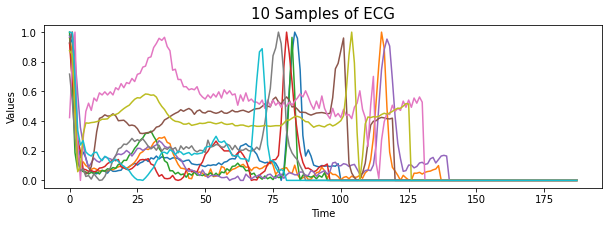

In [4]:
plt.figure(figsize=(10,3))
plt.plot(df_train.iloc[:10, :].T)
plt.title("10 Samples of ECG", fontsize=15)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [6]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.Tensor(data)
        self.used_cols = [x for x in range(data.shape[1]-1)] # X = except target column
        self.target_col = -1 
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index, self.used_cols].unsqueeze(1)
        y = self.data[index, self.target_col].long()
        return x, y

    def __len__(self):
        return len(self.data) 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) # row, col
    
    def __getsize__(self):
        return (self.__len__())

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
num_class = 5
device = 'cuda'
num_epoch = 200
lr = 1e-4

In [8]:
print(len(df_train), len(df_test))

87554 21892


In [9]:
### Stratify Test Dataset to Test/Valid ###
from sklearn.model_selection import train_test_split

train_dataset = MyDataset(df_train.values)

x_valid, x_test, y_valid, y_test = train_test_split(df_test.iloc[:,:-1],df_test.iloc[:,-1], test_size=0.5, shuffle=True, stratify=df_test.iloc[:,-1], random_state=SEED)
df_valid = pd.DataFrame(x_valid)
df_valid.insert(len(df_valid.columns), "target", pd.Series(y_valid))

df_test = pd.DataFrame(x_test)
df_test.insert(len(df_test.columns), "target", pd.Series(y_test))

valid_dataset = MyDataset(df_valid.values)
test_dataset = MyDataset(df_test.values)

In [10]:
### train / valid / test data length ###
print(len(df_train), len(df_valid), len(df_test))

87554 10946 10946


In [11]:
### train label counts ###
df_train.iloc[:, -1].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [12]:
### valid label counts ###
df_valid.iloc[:, -1].value_counts()

0.0    9059
4.0     804
2.0     724
1.0     278
3.0      81
Name: target, dtype: int64

In [13]:
### test label counts ###
df_test.iloc[:, -1].value_counts()

0.0    9059
4.0     804
2.0     724
1.0     278
3.0      81
Name: target, dtype: int64

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. CNN Model (similar architecture w DynamicRouting CapsNet)

In [40]:
result_folder = '../check/cnn/classification/'
os.makedirs(result_folder, exist_ok = True)

attack_result_folder = '../check/cnn/classification_attack/'
os.makedirs(attack_result_folder, exist_ok = True)

In [16]:
class CNN(nn.Module):
    def __init__(self, in_features, out_features, pool_size, hidden_dim, capsule_num):
        super().__init__()
        self.output = out_features
        self.pool_size = pool_size
        
        self.hidden_dim = hidden_dim
        self.capsule_num = capsule_num
        
        self.conv1 = nn.Conv2d(in_features, self.hidden_dim, kernel_size=(9, 1), stride=(1,1))
        
        self.conv2 = nn.Conv2d(self.hidden_dim, self.hidden_dim, kernel_size=(9, 1), stride=(2,1))
        
        self.conv3 = nn.Conv2d(self.hidden_dim, out_features*16, kernel_size=(1,1), stride=(1,1))
        self.pool1 = nn.AdaptiveMaxPool2d(1)
       
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(out_features*16, 512)
        self.fc2 = nn.Linear(512,1024)
        self.out = nn.Linear(1024, out_features)
        
    def visualize(self, x, num_filter, layer, attack=None, num=0):
        x = x.detach().cpu()[num]
        r = int(math.sqrt(num_filter))
        c = int(math.sqrt(num_filter))
        t=0
        try:
            x = x.reshape(r,c,1, -1)
            _, _, _, t = x.size()
        except:
            x = x.reshape(8,10,1,-1)
            _, _, _, t = x.size()
        fig, ax = plt.subplots(r,c,dpi=150)
        for i in range(r):
            for j in range(c):
                ax[i, j].plot(x[i, j, :, :].T)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
        fig.suptitle(layer+f" {num_filter}feature map (1box=1channel)", fontsize=15)
        fig.supxlabel(f"Time Length ({t})", fontsize=10)
        fig.supylabel("Values", fontsize=10)
        if attack == None:
            plt.savefig(result_folder+f'dr_{layer}.png')
        else:
            plt.savefig(attack_result_folder+f'dr_{attack}_{layer}.png')

    def forward(self, x, visualize=False, attack=None, num=0):
        if visualize==True:
            x = F.relu(((self.conv1(x.unsqueeze(1)))))
            self.visualize(x, 256, "Conv1", attack, num)
            x = F.relu(((self.conv2(x))))
            self.visualize(x, 256, "Conv2", attack, num)
            x = self.conv3(x)
            self.visualize(x, 80, "Conv3", attack, num)
            x = F.relu(self.pool1(x))

            x = self.flatten(x).unsqueeze(1)

            x = F.relu(self.fc1(x))
            #self.visualize(x, 256, "layer5")
            x = F.relu(self.fc2(x))
            #self.visualize(x, 256, "layer6")
            x = F.sigmoid(self.out(x))
            #self.visualize2(x, 5, "layer7")
            
        else:
            x = F.relu(((self.conv1(x.unsqueeze(1)))))
            x = F.relu(((self.conv2(x))))
            x = F.relu(self.pool1(self.conv3(x)))

            x = self.flatten(x).unsqueeze(1)
            #print(x.shape)

            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.sigmoid(self.out(x))
        
        return x

In [17]:
from sklearn.utils import class_weight
model = CNN(in_features= 1,
            out_features=num_class,
            pool_size=2, hidden_dim = 256, capsule_num=8).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

y_train = df_train.iloc[:, -1]
class_weight_vec1 = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train.values)
weight1 = torch.Tensor(np.unique(class_weight_vec1)).to(device)
criterion = nn.CrossEntropyLoss(weight=weight1) 

In [18]:
model

CNN(
  (conv1): Conv2d(1, 256, kernel_size=(9, 1), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(9, 1), stride=(2, 1))
  (conv3): Conv2d(256, 80, kernel_size=(1, 1), stride=(1, 1))
  (pool1): AdaptiveMaxPool2d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=80, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=5, bias=True)
)

# 3. Model Training and Evaluation

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [20]:
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list=[]
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    predictions = []
    answers = []
    prob= []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        answers.extend(y.detach().cpu().numpy())

        optimizer.zero_grad()
        outputs = model(x).squeeze()
        #print(outputs.shape)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        prob.extend(torch.nn.Softmax()(outputs).detach().cpu().numpy())
        predictions.extend(torch.max(torch.nn.Softmax()(outputs),1)[1].detach().cpu().numpy())
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_acc = accuracy_score(answers, predictions)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    prob = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x).squeeze()
            loss = criterion(outputs, y) 

            prob.extend(torch.nn.Softmax()(outputs).detach().cpu().numpy())
            predictions.extend(torch.max(torch.nn.Softmax()(outputs),1)[1].detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    valid_acc = accuracy_score(answers, predictions)

    print("epoch: {}/{} | trn: {:.4f} / {:.4f} | val: {:.4f} / {:.4f}".format(
                epoch, num_epoch, train_loss, train_acc, valid_loss, valid_acc
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    """
    if epoch % 20 ==0 :
        torch.save({
            'epoch': epoch,
            'loss' : valid_loss_list[-1],
            'acc' : valid_acc_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swdr-classi-ecg-{epoch}.pt')
    """        
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss' : valid_loss_list[-1],
            'acc' : valid_acc_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swdr-classi-ecg-best.pt')

  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 0/200 | trn: 1.1189 / 0.4255 | val: 1.0966 / 0.6842


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 1/200 | trn: 1.0817 / 0.6875 | val: 1.0855 / 0.7323


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 2/200 | trn: 1.0668 / 0.7257 | val: 1.0408 / 0.7444


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 3/200 | trn: 1.0215 / 0.7538 | val: 1.0248 / 0.7840


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 4/200 | trn: 1.0071 / 0.7912 | val: 1.0031 / 0.8358


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 5/200 | trn: 0.9955 / 0.8353 | val: 0.9989 / 0.8352


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 6/200 | trn: 0.9782 / 0.8500 | val: 0.9855 / 0.8844


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 7/200 | trn: 0.9700 / 0.8622 | val: 0.9720 / 0.8793


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 8/200 | trn: 0.9613 / 0.8654 | val: 0.9645 / 0.8719


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 9/200 | trn: 0.9557 / 0.8581 | val: 0.9616 / 0.8845


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 10/200 | trn: 0.9517 / 0.8728 | val: 0.9521 / 0.8725


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 11/200 | trn: 0.9509 / 0.8700 | val: 0.9524 / 0.8641


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 12/200 | trn: 0.9509 / 0.8755 | val: 0.9513 / 0.8858


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 13/200 | trn: 0.9463 / 0.8925 | val: 0.9509 / 0.9169


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 14/200 | trn: 0.9430 / 0.9023 | val: 0.9521 / 0.9340


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 15/200 | trn: 0.9451 / 0.8973 | val: 0.9517 / 0.9383


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 16/200 | trn: 0.9421 / 0.9054 | val: 0.9463 / 0.9219


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 17/200 | trn: 0.9447 / 0.9025 | val: 0.9476 / 0.9073


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 18/200 | trn: 0.9439 / 0.9041 | val: 0.9484 / 0.8745


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 19/200 | trn: 0.9424 / 0.9071 | val: 0.9447 / 0.8966


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 20/200 | trn: 0.9421 / 0.9068 | val: 0.9461 / 0.8900


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 21/200 | trn: 0.9390 / 0.9181 | val: 0.9509 / 0.9198


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 22/200 | trn: 0.9395 / 0.9132 | val: 0.9444 / 0.9421


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 23/200 | trn: 0.9390 / 0.9146 | val: 0.9426 / 0.9344


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 24/200 | trn: 0.9378 / 0.9183 | val: 0.9415 / 0.9413


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 25/200 | trn: 0.9375 / 0.9211 | val: 0.9400 / 0.9382


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 26/200 | trn: 0.9371 / 0.9237 | val: 0.9419 / 0.9361


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 27/200 | trn: 0.9383 / 0.9212 | val: 0.9418 / 0.9499


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 28/200 | trn: 0.9362 / 0.9221 | val: 0.9494 / 0.8980


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 29/200 | trn: 0.9373 / 0.9217 | val: 0.9403 / 0.9408


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 30/200 | trn: 0.9348 / 0.9316 | val: 0.9396 / 0.9320


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 31/200 | trn: 0.9353 / 0.9290 | val: 0.9409 / 0.9324


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 32/200 | trn: 0.9338 / 0.9277 | val: 0.9399 / 0.9178


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 33/200 | trn: 0.9349 / 0.9256 | val: 0.9414 / 0.9166


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 34/200 | trn: 0.9339 / 0.9237 | val: 0.9469 / 0.8366


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 35/200 | trn: 0.9319 / 0.9365 | val: 0.9379 / 0.9281


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 36/200 | trn: 0.9340 / 0.9311 | val: 0.9396 / 0.9441


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 37/200 | trn: 0.9329 / 0.9323 | val: 0.9396 / 0.9537


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 38/200 | trn: 0.9301 / 0.9385 | val: 0.9536 / 0.9403


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 39/200 | trn: 0.9343 / 0.9284 | val: 0.9384 / 0.9126


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 40/200 | trn: 0.9309 / 0.9371 | val: 0.9366 / 0.9317


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 41/200 | trn: 0.9296 / 0.9398 | val: 0.9397 / 0.9064


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 42/200 | trn: 0.9313 / 0.9327 | val: 0.9396 / 0.9427


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 43/200 | trn: 0.9307 / 0.9382 | val: 0.9355 / 0.9457


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 44/200 | trn: 0.9289 / 0.9430 | val: 0.9364 / 0.9425


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 45/200 | trn: 0.9286 / 0.9401 | val: 0.9431 / 0.9498


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 46/200 | trn: 0.9287 / 0.9412 | val: 0.9413 / 0.9313


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 47/200 | trn: 0.9296 / 0.9383 | val: 0.9383 / 0.9413


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 48/200 | trn: 0.9279 / 0.9367 | val: 0.9337 / 0.9492


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 49/200 | trn: 0.9261 / 0.9456 | val: 0.9337 / 0.9438


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 50/200 | trn: 0.9263 / 0.9441 | val: 0.9347 / 0.9541


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 51/200 | trn: 0.9259 / 0.9450 | val: 0.9331 / 0.9554


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 52/200 | trn: 0.9276 / 0.9399 | val: 0.9358 / 0.9543


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 53/200 | trn: 0.9243 / 0.9495 | val: 0.9374 / 0.9280


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 54/200 | trn: 0.9257 / 0.9443 | val: 0.9308 / 0.9432


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 55/200 | trn: 0.9250 / 0.9452 | val: 0.9360 / 0.9451


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 56/200 | trn: 0.9255 / 0.9456 | val: 0.9334 / 0.9476


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 57/200 | trn: 0.9256 / 0.9419 | val: 0.9320 / 0.9434


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 58/200 | trn: 0.9242 / 0.9480 | val: 0.9327 / 0.9170


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 59/200 | trn: 0.9239 / 0.9473 | val: 0.9320 / 0.9456


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 60/200 | trn: 0.9243 / 0.9414 | val: 0.9346 / 0.9324


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 61/200 | trn: 0.9239 / 0.9473 | val: 0.9341 / 0.9430


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 62/200 | trn: 0.9237 / 0.9447 | val: 0.9328 / 0.9532


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 63/200 | trn: 0.9233 / 0.9495 | val: 0.9311 / 0.9551


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 64/200 | trn: 0.9246 / 0.9439 | val: 0.9328 / 0.9510


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 65/200 | trn: 0.9234 / 0.9527 | val: 0.9290 / 0.9403


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 66/200 | trn: 0.9228 / 0.9509 | val: 0.9318 / 0.9524


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 67/200 | trn: 0.9253 / 0.9461 | val: 0.9319 / 0.9528


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 68/200 | trn: 0.9238 / 0.9487 | val: 0.9301 / 0.9559


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 69/200 | trn: 0.9241 / 0.9475 | val: 0.9312 / 0.9364


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 70/200 | trn: 0.9223 / 0.9515 | val: 0.9323 / 0.9416


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 71/200 | trn: 0.9226 / 0.9496 | val: 0.9377 / 0.8642


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 72/200 | trn: 0.9228 / 0.9492 | val: 0.9321 / 0.9464


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 73/200 | trn: 0.9228 / 0.9489 | val: 0.9301 / 0.9528


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 74/200 | trn: 0.9225 / 0.9494 | val: 0.9303 / 0.9499


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 75/200 | trn: 0.9216 / 0.9533 | val: 0.9308 / 0.9591


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 76/200 | trn: 0.9217 / 0.9528 | val: 0.9313 / 0.9571


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 77/200 | trn: 0.9225 / 0.9489 | val: 0.9325 / 0.9466


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 78/200 | trn: 0.9218 / 0.9521 | val: 0.9308 / 0.9539


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 79/200 | trn: 0.9216 / 0.9518 | val: 0.9309 / 0.9467


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 80/200 | trn: 0.9222 / 0.9530 | val: 0.9287 / 0.9559


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 81/200 | trn: 0.9213 / 0.9521 | val: 0.9297 / 0.9539


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 82/200 | trn: 0.9208 / 0.9554 | val: 0.9309 / 0.9242


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 83/200 | trn: 0.9213 / 0.9529 | val: 0.9304 / 0.9331


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 84/200 | trn: 0.9204 / 0.9566 | val: 0.9304 / 0.9570


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 85/200 | trn: 0.9208 / 0.9559 | val: 0.9304 / 0.9614


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 86/200 | trn: 0.9207 / 0.9562 | val: 0.9292 / 0.9527


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 87/200 | trn: 0.9201 / 0.9580 | val: 0.9310 / 0.9420


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 88/200 | trn: 0.9203 / 0.9560 | val: 0.9318 / 0.9560


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 89/200 | trn: 0.9206 / 0.9550 | val: 0.9309 / 0.9592


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 90/200 | trn: 0.9212 / 0.9529 | val: 0.9327 / 0.9379


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 91/200 | trn: 0.9203 / 0.9561 | val: 0.9290 / 0.9381


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 92/200 | trn: 0.9200 / 0.9575 | val: 0.9344 / 0.9457


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 93/200 | trn: 0.9195 / 0.9597 | val: 0.9282 / 0.9499


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 94/200 | trn: 0.9189 / 0.9587 | val: 0.9301 / 0.9572


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 95/200 | trn: 0.9201 / 0.9568 | val: 0.9314 / 0.9524


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 96/200 | trn: 0.9190 / 0.9595 | val: 0.9311 / 0.9425


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 97/200 | trn: 0.9193 / 0.9590 | val: 0.9281 / 0.9600


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 98/200 | trn: 0.9195 / 0.9557 | val: 0.9445 / 0.9517


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 99/200 | trn: 0.9191 / 0.9587 | val: 0.9313 / 0.9201


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 100/200 | trn: 0.9201 / 0.9506 | val: 0.9312 / 0.9426


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 101/200 | trn: 0.9201 / 0.9539 | val: 0.9302 / 0.9360


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 102/200 | trn: 0.9185 / 0.9580 | val: 0.9305 / 0.9314


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 103/200 | trn: 0.9188 / 0.9586 | val: 0.9293 / 0.9577


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 104/200 | trn: 0.9180 / 0.9607 | val: 0.9314 / 0.9473


  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

epoch: 105/200 | trn: 0.9182 / 0.9606 | val: 0.9339 / 0.9598


  0%|          | 0/1369 [00:00<?, ?it/s]

KeyboardInterrupt: 

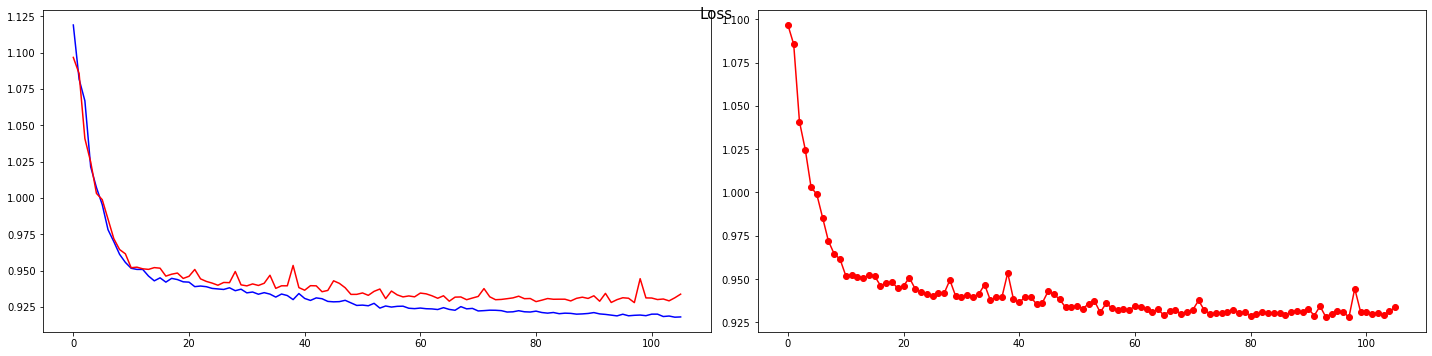

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.tight_layout()
fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'drcnn_loss.png')

In [22]:
pd.DataFrame([train_loss_list, valid_loss_list]).to_csv(result_folder + 'drcnn_loss.csv', index=0)

### Feature Map

In [20]:
checkpoint = torch.load(result_folder + 'cnn-swdr-classi-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['acc'])

97 0.9280573684115743 0.9599853827882332


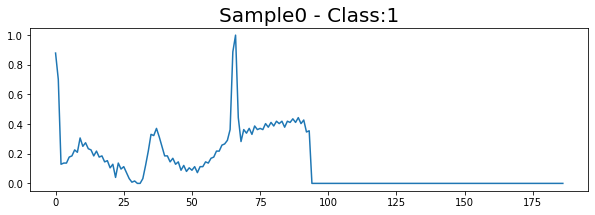

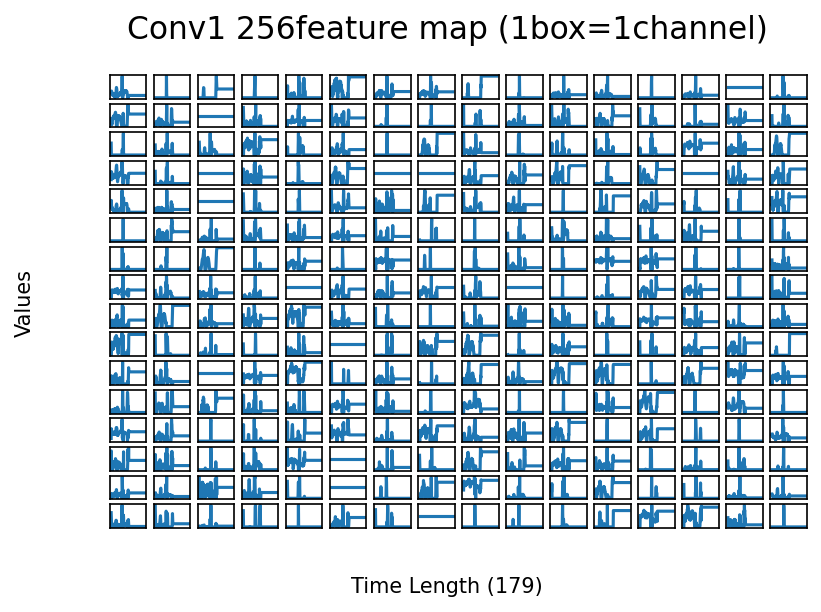

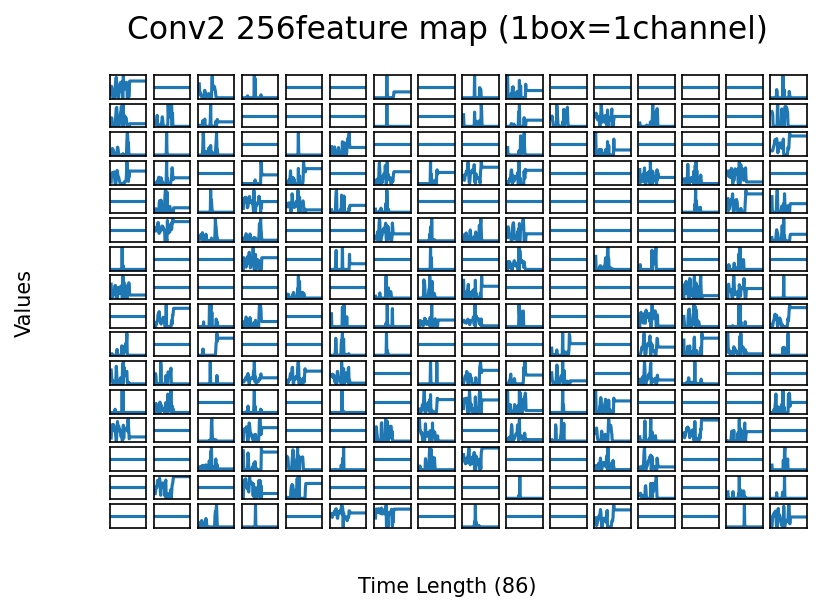

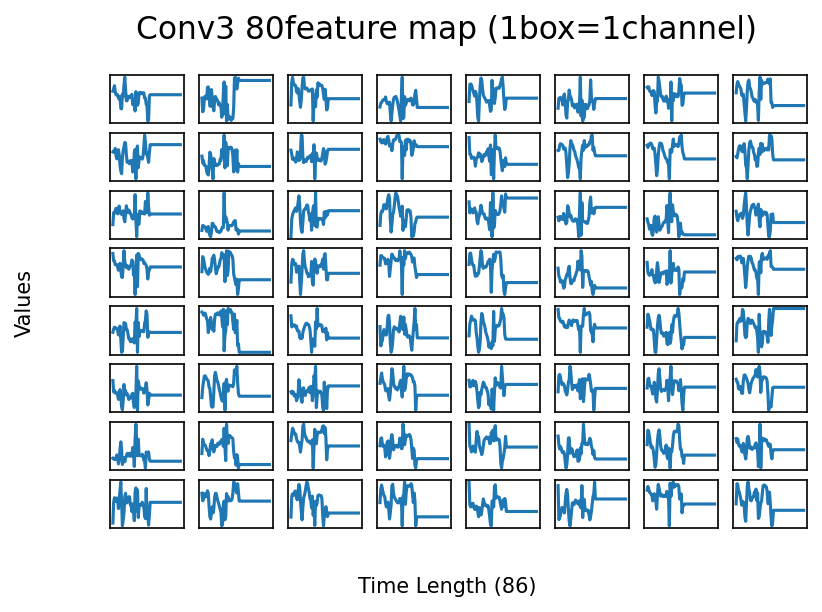

In [21]:
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        
        plt.figure(figsize=(10,3))
        plt.plot(x[0,:,:].detach().cpu().numpy())
        plt.title("Sample0 - Class:"+str(y[0].item()), fontsize=20)
        plt.show()
        
        outputs = model(x, True).squeeze()
        
        if i == 0:
            break

### Performance Evaluation

In [22]:
model = model.eval()
test_loss = []
predictions = []
answers = []
prob = []
with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        answers.extend(y.detach().cpu().numpy())

        outputs = model(x).squeeze()
        loss = criterion(outputs, y) #torch.reshape(y, (-1,1)
            
        prob.extend(torch.nn.Softmax()(outputs).detach().cpu().numpy())
        predictions.extend(torch.max(torch.nn.Softmax()(outputs),1)[1].detach().cpu().numpy())
        
        test_loss.append(loss.item())
    
test_loss = np.mean(test_loss)
acc = accuracy_score(answers, predictions)
f1score = f1_score(answers, predictions, average='weighted')
print (f'Accuracy/test {acc} / {f1score}')

  0%|          | 0/172 [00:00<?, ?it/s]

Accuracy/test 0.9598940252146902 / 0.9617745322425807


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_label, y_pred, normalized=True):
    mat = confusion_matrix(y_label, y_pred)
    cmn = mat.astype('float')
    if normalized:
        cmn = cmn / mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.title("Confusion Matrix (%)", fontsize=15)
    plt.savefig(result_folder + f'drcnn_confmatrix.png')

In [25]:
pd.Series(predictions).value_counts()

0    8861
4     839
2     784
1     309
3     153
dtype: int64

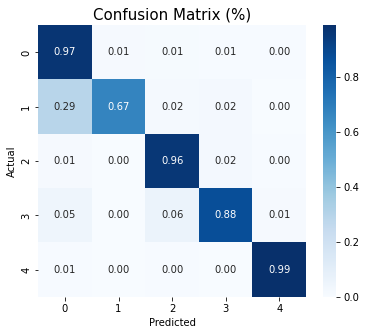

In [26]:
plot_confusion_matrix(answers, predictions)

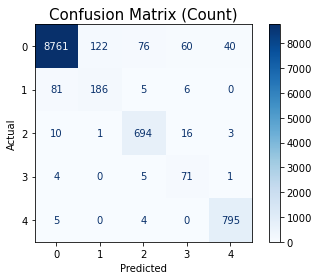

In [27]:
cm = confusion_matrix(answers, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.ylabel('Actual', fontsize=10)
plt.xlabel('Predicted', fontsize=10)
plt.title("Confusion Matrix (Count)", fontsize=15)
plt.savefig(result_folder + f'drcnn_confmatrix2.png')

In [28]:
result_label = pd.DataFrame([answers,predictions])
result_pred = pd.DataFrame([predictions, prob])

result_label.to_csv(result_folder + f'cnndr_classification.csv', index=0)
result_pred.to_csv(result_folder + f'cnndr_classification_prob.csv', index=0)

## Manual Attack

In [29]:
checkpoint = torch.load(result_folder+'cnn-swdr-classi-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['acc'])

97 0.9280573684115743 0.9599853827882332


In [30]:
import copy
### Manual Attack ###
def offset(input_, offset=0.1, window=35, num_sample=1,
           random_noise=True, max_rand_noise=0.01, label_last_col=False, 
           multi_var=0):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    offset: constant value in the range of 0-1, which will be plus added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert offset >= 0 and offset <= 1, "Incorrect range of offset value"
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]

    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)    
    
    if multi_var != 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += offset + noise[j,:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i,start_idx:end_idx] += offset + noise[j,:]
            
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
    
        return x, indices
    
    
def drift(input_, scale=0.1, window=35, num_sample=1, type_='increasing', 
          random_noise=True, max_rand_noise=0.01, label_last_col=False,
          multi_var=0):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    scale: constant value in the range of 0-1, which will be plus increasingly added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    type: options consists of 'increasing' and 'decreasing'
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert scale >= 0 and scale <= 1, "Incorrect range of scale value"
    
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    if len(x.shape)<3:
        start_idx = np.random.randint(0, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)

    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += f + noise[j,:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i, start_idx:end_idx] += f + noise[j,:]
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices
    

def lagging(input_, lag_time=15, num_sample=1, multi_var=0, type_='backward',
            random_noise=True, max_rand_noise=0.01, label_last_col=False):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...).
    lag_time: integer which is lagging duration.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start]
    """
    x = copy.deepcopy(input_)
    assert lag_time >= 0, "Incorrect range of lag time"
#     assert type(lag_time) is int, "Incorrect data type of lag time"
    if label_last_col==True:
        if len(x.shape)>2: # multivariate
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else: #univariate
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    
    idxs = range(num_sample)
    if type_=='backward':
        start_idx = np.random.randint(lag_time, x.shape[1]-2*lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    else: # 'forward'
        start_idx = np.random.randint(2*lag_time, x.shape[1]-lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx), axis=1)            
    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx:x.shape[1],sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:start_idx,sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += noise[:,p]
            else: # 'forward'
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx] = x[i,start_idx:x.shape[1],sensor_idx]
                    x[i,x.shape[1]-lag_time:x.shape[1],sensor_idx] = x[i,x.shape[1]-lag_time,sensor_idx]
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += noise[:,p]
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx-lag_time:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx-lag_tim:x.shape[1]].shape[0]))
                x.iloc[i,start_idx-lag_time:x.shape[1]] = x.iloc[i,start_idx-lag_time:x.shape[1]].shift(periods=lag_time, fill_value=x.iloc[i,start_idx-lag_time])
                x.iloc[i,start_idx-lag_time:x.shape[1]] += noise
            else:
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                x.iloc[i,start_idx:x.shape[1]] = x.iloc[i,start_idx:x.shape[1]].shift(periods=-lag_time-1, fill_value=0)
                x.iloc[i,start_idx:x.shape[1]] += noise     
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices

In [33]:
offsets, offset_idx = offset(df_test, offset=0.1, window=55, num_sample=df_test.shape[0], 
                             max_rand_noise=0.01, label_last_col=True)
increasing, increase_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='increasing',
                            max_rand_noise=0.01, label_last_col=True)
decreasing, decrease_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='decreasing',
                            max_rand_noise=0.01, label_last_col=True)
backward, backward_idx = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="backward", 
                            max_rand_noise=0.01, label_last_col=True)
forward, forward_idx   = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="forward", 
                            max_rand_noise=0.01, label_last_col=True)

offset_test_dataset = MyDataset(offsets.values)
offset_test_loader = torch.utils.data.DataLoader(offset_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

increasing_test_dataset = MyDataset(increasing.values)
increasing_test_loader = torch.utils.data.DataLoader(increasing_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

decreasing_test_dataset = MyDataset(decreasing.values)
decreasing_test_loader = torch.utils.data.DataLoader(decreasing_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

backward_test_dataset = MyDataset(backward.values)
backward_test_loader = torch.utils.data.DataLoader(backward_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

forward_test_dataset = MyDataset(forward.values)
forward_test_loader = torch.utils.data.DataLoader(forward_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

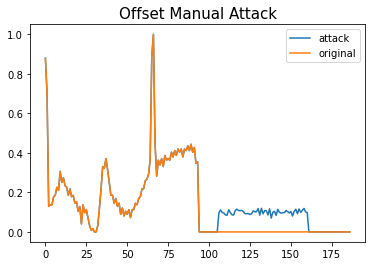

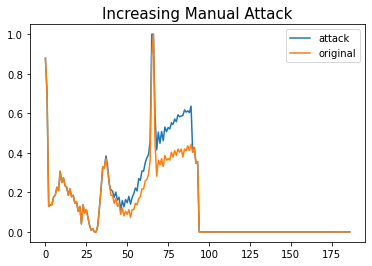

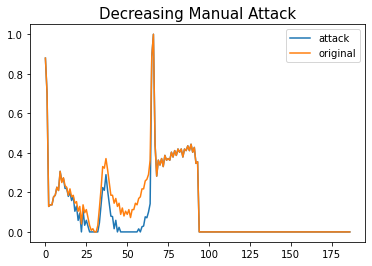

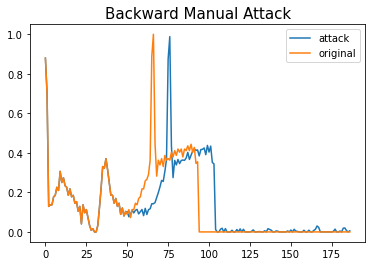

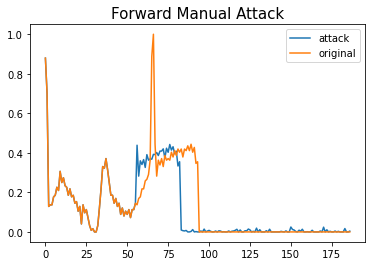

In [35]:
plt.plot(offsets.iloc[offset_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[offset_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Offset Manual Attack", fontsize=15)
plt.show()
plt.plot(increasing.iloc[increase_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[increase_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Increasing Manual Attack", fontsize=15)
plt.show()
plt.plot(decreasing.iloc[decrease_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[decrease_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Decreasing Manual Attack", fontsize=15)
plt.show()
np.random.seed(0)
plt.plot(backward.iloc[backward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[backward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Backward Manual Attack", fontsize=15)
plt.show()
plt.plot(forward.iloc[forward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[forward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Forward Manual Attack", fontsize=15)
plt.show()

In [36]:
def attack_inference(model, test_loader, attack):
    model = model.eval()
    test_loss = []
    predictions = []
    answers = []
    prob = []
    with torch.no_grad():
        for (x, y) in tqdm(test_loader, leave=False):
            x = x.to(device)
            y = y.to(device)

            answers.extend(y.detach().cpu().numpy())

            outputs = model(x).squeeze()
            loss = criterion(outputs, y) #torch.reshape(y, (-1,1)

            prob.extend(torch.nn.Softmax()(outputs).detach().cpu().numpy())
            predictions.extend(torch.max(outputs,1)[1].detach().cpu().numpy())

            test_loss.append(loss.item())

    test_loss = np.mean(test_loss)
    acc = accuracy_score(answers, predictions)
    f1score = f1_score(answers, predictions, average='weighted')
    print (f'{attack} Accuracy/test {acc} / {f1score}')
    
    return answers, predictions, prob

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_label, y_pred, attack, normalized=True):
    mat = confusion_matrix(y_label, y_pred)
    cmn = mat.astype('float')
    if normalized:
        cmn = cmn / mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.title("Confusion Matrix (%)", fontsize=15)
    plt.savefig(attack_result_folder + f'cnn_dr_{attack}_confmatrix.png')

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_max(answers, predictions, attack):
    cm = confusion_matrix(answers, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.title("Confusion Matrix (Count)", fontsize=15)
    plt.savefig(attack_result_folder + f'cnn_dr_{attack}_confmatrix2.png')

  0%|          | 0/172 [00:00<?, ?it/s]

offset Accuracy/test 0.9469212497716061 / 0.9485440104233281


  0%|          | 0/172 [00:00<?, ?it/s]

increasing Accuracy/test 0.9280102320482368 / 0.9322375044298981


  0%|          | 0/172 [00:00<?, ?it/s]

decreasing Accuracy/test 0.9337657591814361 / 0.9387251735880421


  0%|          | 0/172 [00:00<?, ?it/s]

forward Accuracy/test 0.9354101955052074 / 0.9400945566187884


  0%|          | 0/172 [00:00<?, ?it/s]

backward Accuracy/test 0.9464644619038919 / 0.9485643955783833


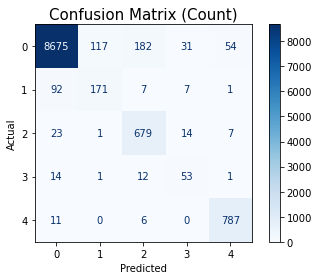

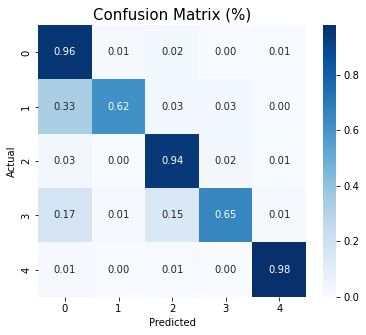

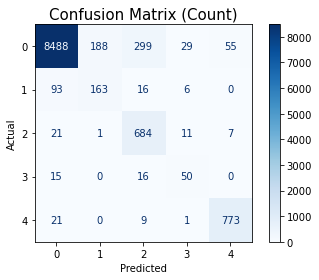

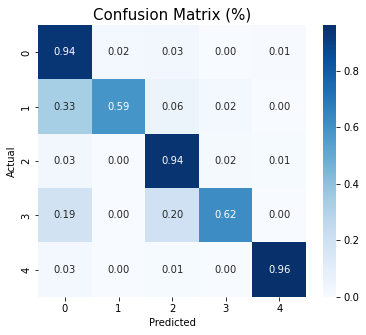

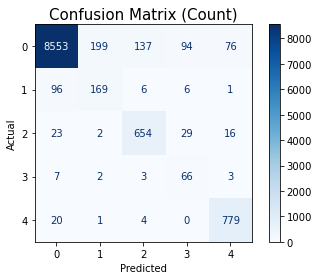

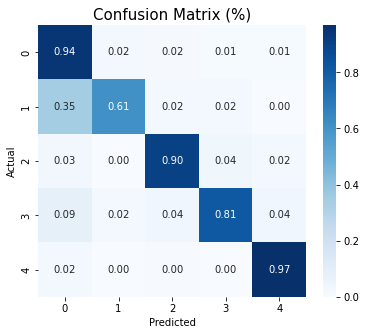

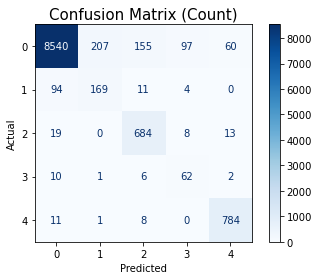

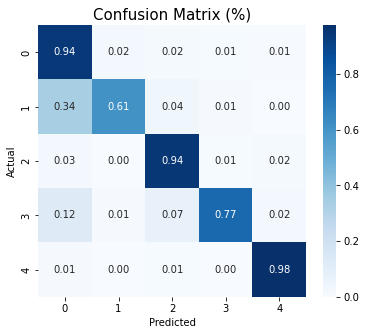

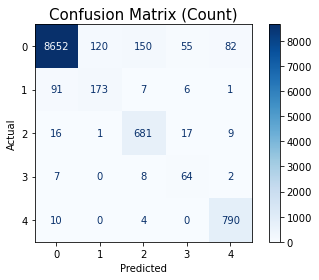

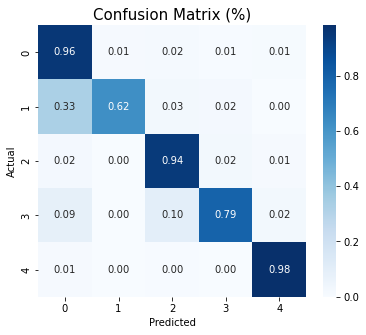

In [41]:
for attack in ['offset', 'increasing', 'decreasing', 'forward', 'backward']:
    if attack == 'offset':
        attack_loader = offset_test_loader 
    if attack == 'increasing':
        attack_loader = increasing_test_loader 
    if attack == 'decreasing':
        attack_loader = decreasing_test_loader 
    if attack == 'forward':
        attack_loader = forward_test_loader 
    if attack == 'backward':
        attack_loader = backward_test_loader 
        
    answers, predictions, prob = attack_inference(model, attack_loader, attack)
    conf_max(answers, predictions, attack)
    plot_confusion_matrix(answers, predictions, attack)
    result_label = pd.DataFrame([answers, predictions])
    result_pred = pd.DataFrame([predictions, prob])
    result_label.to_csv(attack_result_folder + f'cnndr_{attack}_classification.csv')
    result_pred.to_csv(attack_result_folder + f'cnndr_{attack}_classification_prob.csv')

### Attack Feature Map

def attack_feature_map(model, test_loader, true_loader, attack, idx):
    model = model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            if i < (idx[0][0])//64:
                pass
            else:
                x = x.to(device)
                y = y.to(device)
                for i, (x_, y_) in enumerate(true_loader):
                    if i < (idx[0][0])//64:
                        pass
                    else:
                        x_true = x_.to(device)
                        y_true = y_.to(device)
                        break

                label = (idx[0][0]) - (idx[0][0])//64 * 64
                plt.figure(figsize=(10,3))
                plt.plot(x[label,:,:].detach().cpu().numpy(), c = 'blue')
                plt.plot(x_true[label,:,:].detach().cpu().numpy(), c = 'black', ls=':')
                plt.title(f"Sample{idx[0][0]} - Class:"+str(y[label].item()), fontsize=20)
                plt.show()

                outputs = model(x, True, attack, label).squeeze()

                break

attack_feature_map(model,offset_test_loader, test_loader, 'offset_attack', offset_idx)
attack_feature_map(model,increasing_test_loader, test_loader, 'increasing_attack', increase_idx)
attack_feature_map(model,decreasing_test_loader, test_loader, 'decreasing_attack', decrease_idx)
attack_feature_map(model,laggings_test_loader, test_loader, 'laggings_attack', lag_idx)

## Balck Box Attack - fgsm

In [42]:
fgsm_attack = pd.read_csv(data_folder +'ECG_adv-eps-0.1-test.csv')
fgsm_attack = fgsm_attack.loc[df_test.index]
len(fgsm_attack)

10946

In [43]:
fgsm_test_dataset = MyDataset(fgsm_attack.values)
fgsm_test_loader = torch.utils.data.DataLoader(fgsm_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

  0%|          | 0/172 [00:00<?, ?it/s]

fgsm Accuracy/test 0.72528777635666 / 0.7525459618903423


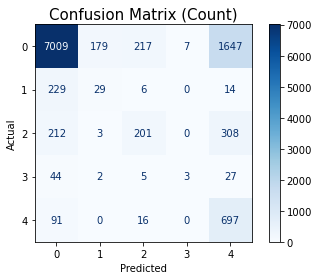

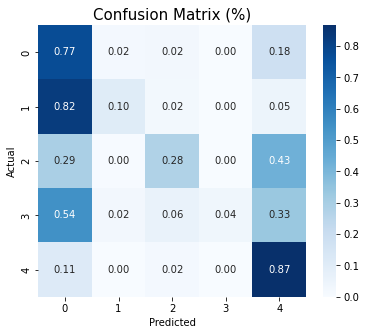

In [44]:
attack = 'fgsm'
answers, predictions, prob = attack_inference(model, fgsm_test_loader, attack)
conf_max(answers, predictions, attack)
plot_confusion_matrix(answers, predictions, attack)
result_label = pd.DataFrame([answers, predictions])
result_pred = pd.DataFrame([predictions, prob])
result_label.to_csv(attack_result_folder + f'cnndr_{attack}_classification.csv')
result_pred.to_csv(attack_result_folder + f'cnndr_{attack}_classification_prob.csv')